# Import Package

In [1]:
SEED = 42

# 基本套件
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd
import os
from datetime import datetime

# Categorical Data Transforming
import category_encoders as ce
from sklearn.impute import KNNImputer

# Change Scaler
from sklearn.preprocessing import StandardScaler

# 資料集切割
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import StratifiedKFold

# 特徵篩選
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# 使用模型
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import catboost as cb
import lightgbm as lgbm
# import tensorflow as tf


# 資料視覺化
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


# 最佳化參數
import optuna
from optuna.integration import LightGBMPruningCallback

os.getcwd()

C:\Users\USER\anaconda3\envs\tensorflow_new\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'C:\\Users\\USER\\Desktop\\Kev\\碩一\\人工智慧\\HW2'

# Read data

In [2]:
df = pd.read_csv(r'./train.csv')
print('view the data shape', df.shape)
df.head()

view the data shape (10108, 9)


,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,0,2008/9/30,Female,Service,No,2,3.0,3.8,0.16
1,1,2008/11/30,Male,Service,Yes,1,2.0,5.0,0.36
2,2,2008/3/10,Female,Product,Yes,2,NaN,5.8,0.49
3,3,2008/11/3,Male,Service,Yes,1,1.0,2.6,0.20
4,4,2008/7/24,Female,Service,No,3,7.0,6.9,0.52


In [3]:
# elliminate traget not na
df = df[df['Burn Rate'].notna()]

In [4]:
df = df[df.columns[1:]]
X = df[df.columns[:-1]]
y = df[df.columns[-1]]

C:\Users\USER\AppData\Local\Temp\ipykernel_9740\58359773.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr())


<AxesSubplot: >

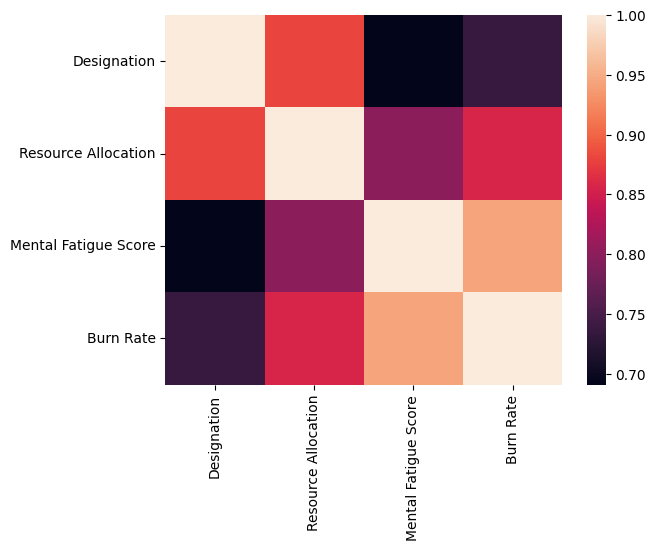

In [5]:
sns.heatmap(df.corr())

In [6]:
df.describe()

,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
count,9624.000000,9041.000000,8738.000000,9624.000000
mean,2.183292,4.500055,5.731231,0.452351
std,1.141031,2.051501,1.921508,0.198787
min,0.000000,1.000000,0.000000,0.000000
25%,1.000000,3.000000,4.600000,0.320000
50%,2.000000,4.000000,5.900000,0.450000
75%,3.000000,6.000000,7.100000,0.590000
max,5.000000,10.000000,10.000000,1.000000


# Data Preprocessing

## Transfer Time related Data

In [7]:
def transfer_date(date):
    date_format = "%Y/%m/%d"
    a = datetime.strptime('2022/10/10', date_format)
    b = datetime.strptime(date, date_format)
    delta = a - b
    return delta.days

In [8]:
X['Date of Joining'] = X['Date of Joining'].apply(lambda x : transfer_date(x))

C:\Users\USER\AppData\Local\Temp\ipykernel_9740\1446608504.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Date of Joining'] = X['Date of Joining'].apply(lambda x : transfer_date(x))


## Categorical Data Transforming -  Target Encoder

In [9]:
## 原類別型
ce_leave = ce.GLMMEncoder(cols = ['Gender','Company Type','WFH Setup Available'],binomial_target = False,handle_unknown='value')
ce_leave.fit(X, y)     
X = ce_leave.transform(X)

## Normalize Data

In [10]:
# Normalization
Normalize_scaler = StandardScaler()
X = pd.DataFrame(Normalize_scaler.fit_transform(X), columns=X.columns, index=X.index)

## Fill Missing Value - KNN Imputer

In [11]:
X.isna().sum()

Date of Joining           0
Gender                    0
Company Type              0
WFH Setup Available       0
Designation               0
Resource Allocation     583
Mental Fatigue Score    886
dtype: int64

In [12]:
# TODO
imputer = KNNImputer(n_neighbors=5)
X = pd.DataFrame(imputer.fit_transform(X),columns = X.columns)

In [13]:
X.isna().sum()

Date of Joining         0
Gender                  0
Company Type            0
WFH Setup Available     0
Designation             0
Resource Allocation     0
Mental Fatigue Score    0
dtype: int64

In [14]:
X.reset_index(drop=True,inplace=True)
y.reset_index(drop=True,inplace=True)

# EDA

<AxesSubplot: >

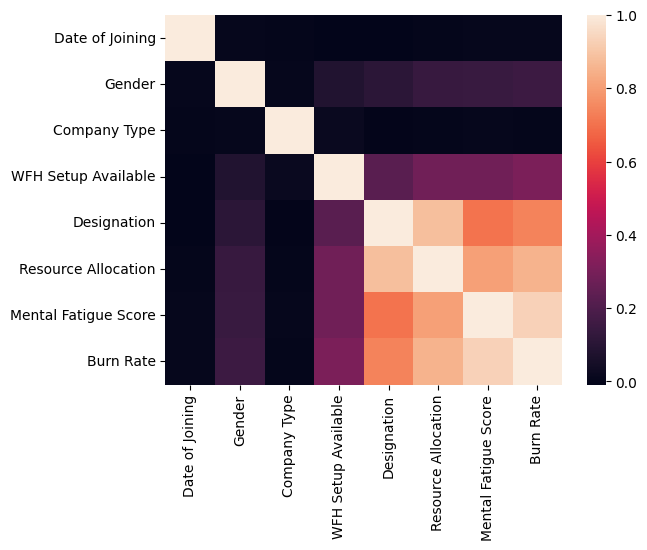

In [15]:
df = pd.concat([X,y],axis=1)
sns.heatmap(df.corr())

# Feature Selection

In [16]:
# begin SFS
model_lgbm = lgbm.LGBMRegressor(random_state=SEED)
sfs_LGBM = SFS(model_lgbm, 
           k_features= int(round(X.shape[1],0)), 
           floating=True,# 可以改false，如果跑太久
           forward=True,  
           verbose=2,
           cv=5,
           n_jobs=4)
sfs_LGBM = sfs_LGBM.fit(X, y)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   4 out of   7 | elapsed:    1.0s remaining:    0.7s
[Parallel(n_jobs=4)]: Done   7 out of   7 | elapsed:    1.2s finished

[2022-10-17 13:58:12] Features: 1/7 -- score: 0.8698794873049049[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of   6 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   6 out of   6 | elapsed:    0.3s finished

[2022-10-17 13:58:12] Features: 2/7 -- score: 0.897274538263304[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.0s finished

[2022-10-17 13:58:14] Features: 3/7 -- score: 0.8994543361130042[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent 

In [17]:
pd.DataFrame(sfs_LGBM.get_metric_dict())

,1,2,3,4,5,6,7
feature_idx,"(6,)","(5, 6)","(4, 5, 6)","(3, 4, 5, 6)","(2, 3, 4, 5, 6)","(1, 2, 3, 4, 5, 6)","(0, 1, 2, 3, 4, 5, 6)"
cv_scores,"[0.8795551210649553, 0.8697820618171753, 0.874...","[0.907161764083326, 0.896535543495723, 0.90135...","[0.9100334314388974, 0.8986141694573998, 0.902...","[0.9113197443621612, 0.8992090808754988, 0.903...","[0.9107333586350557, 0.8986295095478738, 0.904...","[0.9112190293886943, 0.8989834069340188, 0.903...","[0.9106804850053196, 0.8989778083988269, 0.904..."
avg_score,0.869879,0.897275,0.899454,0.900928,0.900621,0.9007,0.900609
feature_names,"(Mental Fatigue Score,)","(Resource Allocation, Mental Fatigue Score)","(Designation, Resource Allocation, Mental Fati...","(WFH Setup Available, Designation, Resource Al...","(Company Type, WFH Setup Available, Designatio...","(Gender, Company Type, WFH Setup Available, De...","(Date of Joining, Gender, Company Type, WFH Se..."
ci_bound,0.009122,0.008584,0.008592,0.008047,0.008051,0.008159,0.007955
std_dev,0.007097,0.006678,0.006685,0.006261,0.006264,0.006348,0.006189
std_err,0.003548,0.003339,0.003342,0.00313,0.003132,0.003174,0.003094


In [18]:
pd.DataFrame(sfs_LGBM.get_metric_dict()).loc['feature_names',4]

('WFH Setup Available',
 'Designation',
 'Resource Allocation',
 'Mental Fatigue Score')

# Hypterparameter tuning - Optuna

In [20]:
# 分成不同盒子 - 分層抽樣用
def get_box(df):
    Y1_list = []
    for Y1 in df['Burn Rate']: 
        if (Y1 > np.percentile(df['Burn Rate'], 80)):
            Y1_list.append('3')
        elif (Y1 < np.percentile(df['Burn Rate'], 20)):
            Y1_list.append('2')
        else:
            Y1_list.append('1')
    df['box'] = Y1_list
    return df

In [41]:
# 分層抽樣因子
df = get_box(df)

X = df[df.columns[:-2]]
y = df[df.columns[-2:]]

# TODO
X = X.loc[:,X.columns.isin(['WFH Setup Available','Designation', 'Resource Allocation', 'Mental Fatigue Score'])]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y['box'])


X_train.reset_index(drop=True,inplace=True)
X_valid.reset_index(drop=True,inplace=True) 
y_train.reset_index(drop=True,inplace=True) 
y_valid.reset_index(drop=True,inplace=True)


In [42]:
def objective_lgbm(trial):
    param = {
        'metric': 'rmse',
        'n_estimators': 20000,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)
    }
    
    model = lgbm.LGBMRegressor(**param,random_state=SEED)
    model.fit(X_train,y_train['Burn Rate'],eval_set=[(X_valid, y_valid['Burn Rate'])],early_stopping_rounds=100,verbose=False)
    y_pred = model.predict(X_valid)
    pred_list = y_pred.tolist()
    act_list = y_valid['Burn Rate'].tolist()

    error_list = []   
    for i in range(0, len(y_pred)):
        error_list.append(abs(round(act_list[i] - pred_list[i], 4)))
    abs_error_list_r4 =  [abs(ele) for ele in error_list]
    
    return sum(abs_error_list_r4)/len(abs_error_list_r4)

In [43]:
#optuna to set the hyperparameter of XGBoost
def objective_xgb(trial):
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 6, 15),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 500, 2000, 100),
        'eta': trial.suggest_float("eta", 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'gamma': trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 2, 10),
        'grow_policy': trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0)
    }
    model = xgb.XGBRegressor(**param,tree_method='gpu_hist',random_state=SEED).fit(X_train,y_train['Burn Rate'])
    y_pred = model.predict(X_valid)
    pred_list = y_pred.tolist()
    act_list = y_valid['Burn Rate'].tolist()

    error_list = []   
    for i in range(0, len(y_pred)):
        error_list.append(abs(round(act_list[i] - pred_list[i], 4)))
    abs_error_list_r4 =  [abs(ele) for ele in error_list]
    
    return sum(abs_error_list_r4)/len(abs_error_list_r4)

In [44]:
def objective_cat(trial):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    param = {
        "loss_function": trial.suggest_categorical("loss_function", ["RMSE", "MAE"]),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e0),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-2, 1e0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 10),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 20),
        "one_hot_max_size": trial.suggest_int("one_hot_max_size", 2, 20),  
    }
    # Conditional Hyper-Parameters
    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    reg = cb.CatBoostRegressor(**param)
    reg.fit(X_train, y_train['Burn Rate'], verbose=0, early_stopping_rounds=100)
    y_pred = reg.predict(X_valid)
    pred_list = y_pred.tolist()
    act_list = y_valid['Burn Rate'].tolist()

    error_list = []   
    for i in range(0, len(y_pred)):
        error_list.append(abs(round(act_list[i] - pred_list[i], 4)))
    abs_error_list_r4 =  [abs(ele) for ele in error_list]
    
    return sum(abs_error_list_r4)/len(abs_error_list_r4)

In [45]:
# # optuna
# study_xgb = optuna.create_study(direction="minimize")
# study_xgb.optimize(objective_xgb, n_trials=100)

In [46]:
# # optuna
# study_cat = optuna.create_study(direction="minimize")
# study_cat.optimize(objective_cat, n_trials=100)

In [47]:
# optuna
study_lgbm = optuna.create_study(direction="minimize")
study_lgbm.optimize(objective_lgbm, n_trials=100)

[I 2022-10-17 14:00:51,599] A new study created in memory with name: no-name-f82855f7-4cd6-419d-ad6e-0dc5727f77e7
C:\Users\USER\AppData\Local\Temp\ipykernel_9740\3053857354.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\USER\AppData\Local\Temp\ipykernel_9740\3053857354.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
C:\Users\USER\anaconda3\envs\tensorflow_new\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release

[I 2022-10-17 14:01:11,103] Trial 18 finished with value: 0.04972540259740269 and parameters: {'reg_alpha': 0.1669623158201437, 'reg_lambda': 0.3801116469200146, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 20, 'num_leaves': 195, 'min_child_samples': 84, 'min_data_per_groups': 16}. Best is trial 18 with value: 0.04972540259740269.
[I 2022-10-17 14:01:11,493] Trial 19 finished with value: 0.05000618181818182 and parameters: {'reg_alpha': 0.16379250507222956, 'reg_lambda': 0.24027663083774825, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 100, 'num_leaves': 6, 'min_child_samples': 92, 'min_data_per_groups': 19}. Best is trial 18 with value: 0.04972540259740269.
[I 2022-10-17 14:01:11,979] Trial 20 finished with value: 0.05011200000000001 and parameters: {'reg_alpha': 1.2769292026081225, 'reg_lambda': 0.018203381141784953, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 20, 'num_leaves': 1

[I 2022-10-17 14:01:25,476] Trial 40 finished with value: 0.04986638961038953 and parameters: {'reg_alpha': 0.008981507537135615, 'reg_lambda': 0.07595015370503772, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.006, 'max_depth': 10, 'num_leaves': 81, 'min_child_samples': 33, 'min_data_per_groups': 6}. Best is trial 38 with value: 0.0496531948051948.
[I 2022-10-17 14:01:26,591] Trial 41 finished with value: 0.05015163636363642 and parameters: {'reg_alpha': 0.008027311742207638, 'reg_lambda': 0.15435926373975242, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.006, 'max_depth': 10, 'num_leaves': 138, 'min_child_samples': 7, 'min_data_per_groups': 11}. Best is trial 38 with value: 0.0496531948051948.
[I 2022-10-17 14:01:27,320] Trial 42 finished with value: 0.04980275324675317 and parameters: {'reg_alpha': 0.02111506614046251, 'reg_lambda': 0.029246703343915416, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.006, 'max_depth': 10, 'num_leaves': 

[I 2022-10-17 14:01:46,494] Trial 62 finished with value: 0.04977968831168841 and parameters: {'reg_alpha': 0.4264922467896754, 'reg_lambda': 0.002103819580081347, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.006, 'max_depth': 10, 'num_leaves': 679, 'min_child_samples': 50, 'min_data_per_groups': 57}. Best is trial 52 with value: 0.04957231168831157.
[I 2022-10-17 14:01:46,856] Trial 63 finished with value: 0.04976379220779212 and parameters: {'reg_alpha': 0.2651837651318343, 'reg_lambda': 0.0013608978889055716, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 10, 'num_leaves': 600, 'min_child_samples': 90, 'min_data_per_groups': 51}. Best is trial 52 with value: 0.04957231168831157.
[I 2022-10-17 14:01:50,501] Trial 64 finished with value: 0.05125324675324668 and parameters: {'reg_alpha': 2.0449356533146514, 'reg_lambda': 0.005859589241108604, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.006, 'max_depth': 10, 'num_leaves'

[I 2022-10-17 14:02:04,348] Trial 84 finished with value: 0.04972893506493503 and parameters: {'reg_alpha': 0.5064843450688178, 'reg_lambda': 3.9882867099583366, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.017, 'max_depth': 100, 'num_leaves': 585, 'min_child_samples': 33, 'min_data_per_groups': 80}. Best is trial 69 with value: 0.04955163636363634.
[I 2022-10-17 14:02:05,815] Trial 85 finished with value: 0.05060732467532472 and parameters: {'reg_alpha': 0.29517260587507127, 'reg_lambda': 0.0011156540015138535, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.008, 'max_depth': 100, 'num_leaves': 621, 'min_child_samples': 46, 'min_data_per_groups': 85}. Best is trial 69 with value: 0.04955163636363634.
[I 2022-10-17 14:02:06,185] Trial 86 finished with value: 0.04961189610389604 and parameters: {'reg_alpha': 0.3836053213739505, 'reg_lambda': 3.334330768161852, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.017, 'max_depth': 10, 'num_leaves':

# Modeling

## Training (model construction)

In [48]:
y = y[y.columns[0]]

In [49]:
study_lgbm.best_trial.params

{'reg_alpha': 0.6036620931981621,
 'reg_lambda': 0.0024516413218263373,
 'colsample_bytree': 1.0,
 'subsample': 1.0,
 'learning_rate': 0.017,
 'max_depth': 10,
 'num_leaves': 479,
 'min_child_samples': 6,
 'min_data_per_groups': 46}

### Modeling

In [54]:
# TODO
# build model with best hyperparameter
model_lgbm = lgbm.LGBMRegressor(**study_lgbm.best_trial.params,random_state=SEED)

## Cross validation
- usually we will do cross validation to evaluate the generalization of model
- or you can just use ```sklearn.model_selection.train_test_split``` to evaluate your model

In [55]:
# TODO
# Using Stratified K fold to find result
# skf = StratifiedKFold(n_splits=5,random_state=SEED)

scores = cross_val_score(model_lgbm, X, y, cv=5)
print("R2: %0.2f (std: %0.2f)" % (scores.mean(), scores.std()))
print(scores)
# need other scoring
scores = cross_validate(model_lgbm, X, y, cv=5,
                       scoring=('r2', 'neg_mean_squared_error', 'neg_mean_absolute_percentage_error'))
print("====================================")
print("R2: {} (std: {})".format(scores['test_r2'].mean(), scores['test_r2'].std()))
print("MSE: {} (std: {})".format(-scores['test_neg_mean_squared_error'].mean(), scores['test_neg_mean_squared_error'].std()))
print("MAPE: {} (std: {})".format(-scores['test_neg_mean_absolute_percentage_error'].mean(), scores['test_neg_mean_absolute_percentage_error'].std()))

[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
R2: 0.87 (std: 0.01)
[0.87653744 0.86255151 0.87059379 0.86024969 0.86000398]
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
R2: 0.8659872818868755 (std: 0.006527634836951438)
MSE: 0.005285674827230669 (std: 0.0002149463882814812)
MAPE: 6975593790393.354 (std: 1530747611951.6409)


# Prediction
1. read data
2. model prediction
3. to_csv

In [57]:
df_test = pd.read_csv(r'./test.csv')
print(df_test.shape)
df_test.head()

(1980, 8)


,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score
0,0,2008/11/12,Male,Service,Yes,0,1.0,0.0
1,1,2008/3/11,Male,Product,No,3,8.0,7.9
2,2,2008/4/3,Male,Service,No,4,9.0,8.1
3,3,2008/10/1,Male,Product,No,1,3.0,5.7
4,4,2008/1/5,Female,Service,No,3,5.0,NaN


In [58]:
X_test = df_test[df_test.columns[1:]]

## Data Preprocessing for testing

## Transfer Time related Data

In [59]:
def transfer_date(date):
    date_format = "%Y/%m/%d"
    a = datetime.strptime('2022/10/10', date_format)
    b = datetime.strptime(date, date_format)
    delta = a - b
    return delta.days

In [60]:
X_test['Date of Joining'] = X_test['Date of Joining'].apply(lambda x : transfer_date(x))

C:\Users\USER\AppData\Local\Temp\ipykernel_9740\345012162.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Date of Joining'] = X_test['Date of Joining'].apply(lambda x : transfer_date(x))


## Categorical Data Transforming -  Target Encoder

In [61]:
## 原類別型
X_test = ce_leave.transform(X_test)

## Normalize Data

In [62]:
# Normalization
X_test = pd.DataFrame(Normalize_scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

## Fill Missing Value - KNN Imputer

In [63]:
X_test.isna().sum()

Date of Joining           0
Gender                    0
Company Type              0
WFH Setup Available       0
Designation               0
Resource Allocation     110
Mental Fatigue Score    186
dtype: int64

In [64]:
X_test = pd.DataFrame(imputer.transform(X_test),columns = X_test.columns)

## Feature Selection

In [65]:
# TODO
X_test = X_test.loc[:,X_test.columns.isin(['WFH Setup Available','Designation', 'Resource Allocation', 'Mental Fatigue Score'])]

## Predict Testing set

In [66]:
model_lgbm.fit(X,y,verbose=False)

[LightGBM] [Warning] Unknown parameter: min_data_per_groups


C:\Users\USER\anaconda3\envs\tensorflow_new\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


LGBMRegressor(learning_rate=0.017, max_depth=10, min_child_samples=6,
              min_data_per_groups=46, num_leaves=479, random_state=42,
              reg_alpha=0.6036620931981621, reg_lambda=0.0024516413218263373)

In [67]:
y_pred = model_lgbm.predict(X_test)

In [68]:
y_pred_output = []
for i in y_pred:
    if i<0:
        y_pred_output.append(0)
    elif i>1:
        y_pred_output.append(1)
    else:
        y_pred_output.append(i)
        
y_pred_output = pd.DataFrame(y_pred_output,columns=['Burn Rate'])

# Output .csv for submission

In [69]:
df_ans = pd.DataFrame(y_pred_output.astype(float), columns=['Burn Rate'])
df_ans.to_csv('mySubmission.csv', index_label='Employee ID')

In [70]:
df_ans

,Burn Rate
0,0.098886
1,0.682873
2,0.715152
3,0.409750
4,0.478948
...,...
1975,0.239894
1976,0.458333
1977,0.357410
1978,0.549004
